In [66]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [67]:
df = pd.read_parquet("data.parquet")

In [68]:
print(f"Years in which orders were placed: {df['order_year'].unique()}.")
print(f"Years in which deliveries were made: {df['ship_year'].unique()}.")

Years in which orders were placed: [2016 2015 2014 2017].
Years in which deliveries were made: [2016 2015 2014 2017 2018].


In [89]:
sum_profit = df["profit"].sum()
sum_quantity = df["quantity"].sum()
median_profit = df["profit"].median()
min_profit = df["profit"].min()
max_profit =df["profit"].max()
print(f"Durchscnittserlös von {sum_profit/ sum_quantity} per Unit. \n Durchschnittserlös pro Transaktion:  {sum_profit / len(df)}  \n Median: {median_profit} \n Min Profit: {min_profit} \n  Max Profit: {max_profit}" )


Durchscnittserlös von 7.562036852111002 per Unit. 
 Durchschnittserlös pro Transaktion:  28.65689630778467  
 Median: 8.6665 
 Min Profit: -6599.978 
  Max Profit: 8399.976


## Diagramme

In [69]:
def draw_styled_plot(ax, x_data, y_data, label, title="", ylabel="", 
                     linestyle='-', color=None, is_percent=False):
    
    ax.plot(x_data, y_data, 
            marker='o', 
            linewidth=2.5, 
            linestyle=linestyle, 
            label=label,
            color=color)
    
    if title:
        ax.set_title(title, fontweight='bold')
    if ylabel:
        ax.set_ylabel(ylabel)
        
    ax.grid(True, linestyle='--', alpha=0.7)
    
    if label:
        ax.legend(loc='upper left', fontsize='small')

    if is_percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        for x, y in zip(x_data, y_data):
            if pd.notnull(y):
                ax.text(x, y, 
                        f"{y:.1f}%", 
                        fontsize=9, ha='center', va='bottom', 
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

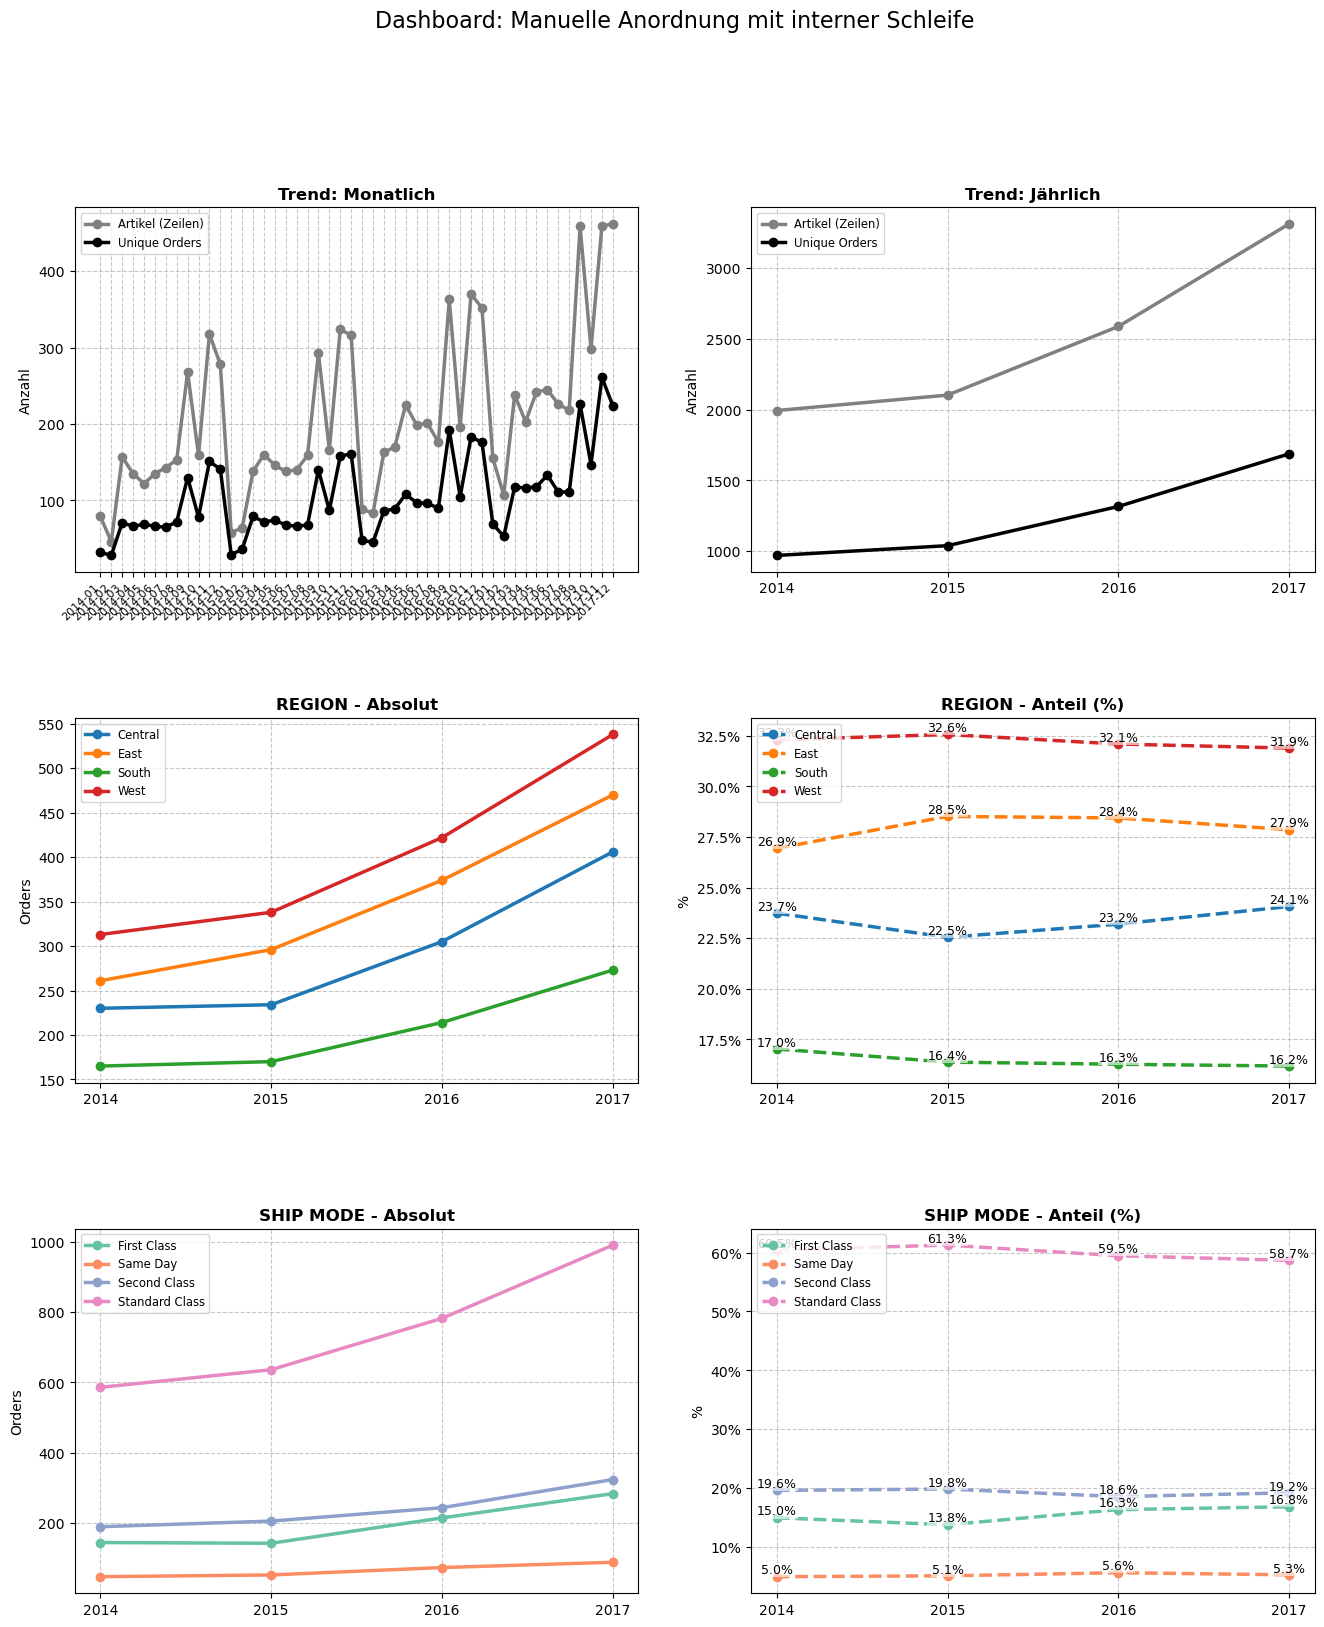

In [70]:


# ---------------------------------------------------------
# 2. DATEN VORBEREITUNG (Global)
# ---------------------------------------------------------

# Datum formatieren
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.to_period('M').astype(str)

# Listen für die X-Achsen
years = sorted(df['order_year'].unique())
months = sorted(df['order_month'].unique())

# Daten für Zeile 1 (Allgemeiner Überblick)
stats_monthly = df.groupby('order_month').agg(rows=('order_id', 'count'), orders=('order_id', 'nunique')).reset_index()
stats_yearly = df.groupby('order_year').agg(rows=('order_id', 'count'), orders=('order_id', 'nunique')).reset_index()

# Gesamtsummen pro Jahr für die Prozentrechnung der Kategorien
yearly_totals = df.groupby('order_year')['order_id'].nunique()


# ---------------------------------------------------------
# 3. PLOTTING SETUP
# ---------------------------------------------------------
# Wir definieren explizit 3 Zeilen:
# Zeile 0: Allgemein (Monatlich & Jährlich)
# Zeile 1: Region (Absolut & Relativ)
# Zeile 2: Ship Mode (Absolut & Relativ)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.2) # Abstände anpassen

fig.suptitle('Dashboard: Manuelle Anordnung mit interner Schleife', fontsize=16, y=0.99)


# =============================================================================
# BLOCK 1: ALLGEMEINE ENTWICKLUNG (Zeile 0)
# =============================================================================

# --- Oben Links: Monatliche Entwicklung (Detail) ---
ax_month = axes[0, 0]

# Hier brauchen wir keine Schleife, es sind nur 2 spezifische Linien
draw_styled_plot(ax=ax_month, x_data=stats_monthly['order_month'], y_data=stats_monthly['rows'],
                 label='Artikel (Zeilen)', title='Trend: Monatlich', ylabel='Anzahl', color='grey')

draw_styled_plot(ax=ax_month, x_data=stats_monthly['order_month'], y_data=stats_monthly['orders'],
                 label='Unique Orders', color='black')

# X-Achse formatieren (Monate rotieren)
ax_month.set_xticks(range(len(months)))
ax_month.set_xticklabels(months, rotation=45, ha='right', fontsize=8)


# --- Oben Rechts: Jährliche Entwicklung (Überblick) ---
ax_year = axes[0, 1]

draw_styled_plot(ax=ax_year, x_data=stats_yearly['order_year'], y_data=stats_yearly['rows'],
                 label='Artikel (Zeilen)', title='Trend: Jährlich', ylabel='Anzahl', color='grey')

draw_styled_plot(ax=ax_year, x_data=stats_yearly['order_year'], y_data=stats_yearly['orders'],
                 label='Unique Orders', color='black')

ax_year.set_xticks(years)


# =============================================================================
# BLOCK 2: REGION (Zeile 1)
# =============================================================================

# 1. Daten berechnen für Region
df_reg = df.groupby(['order_year', 'region'])['order_id'].nunique().reset_index()
df_reg = df_reg.merge(yearly_totals.rename('total'), on='order_year')
df_reg['pct'] = (df_reg['order_id'] / df_reg['total']) * 100

# 2. Setup für Region-Plots
ax_reg_abs = axes[1, 0]
ax_reg_rel = axes[1, 1]
unique_regions = df_reg['region'].unique()
colors_reg = sns.color_palette("tab10", len(unique_regions)) # Farben generieren

# 3. Interne Schleife (Nur für Region!)
for i, region in enumerate(unique_regions):
    subset = df_reg[df_reg['region'] == region]
    c = colors_reg[i]
    
    # Links: Absolut
    draw_styled_plot(ax=ax_reg_abs, x_data=subset['order_year'], y_data=subset['order_id'],
                     label=region, title='REGION - Absolut', ylabel='Orders', color=c)
    
    # Rechts: Relativ
    draw_styled_plot(ax=ax_reg_rel, x_data=subset['order_year'], y_data=subset['pct'],
                     label=region, title='REGION - Anteil (%)', ylabel='%', 
                     linestyle='--', color=c, is_percent=True)

# Achsen setzen
ax_reg_abs.set_xticks(years)
ax_reg_rel.set_xticks(years)


# =============================================================================
# BLOCK 3: SHIP MODE (Zeile 2)
# =============================================================================

# 1. Daten berechnen für Ship Mode
df_ship = df.groupby(['order_year', 'ship_mode'])['order_id'].nunique().reset_index()
df_ship = df_ship.merge(yearly_totals.rename('total'), on='order_year')
df_ship['pct'] = (df_ship['order_id'] / df_ship['total']) * 100

# 2. Setup für Ship-Plots
ax_ship_abs = axes[2, 0]
ax_ship_rel = axes[2, 1]
unique_modes = df_ship['ship_mode'].unique()
colors_ship = sns.color_palette("Set2", len(unique_modes)) # Andere Farbpalette zur Unterscheidung

# 3. Interne Schleife (Nur für Ship Mode!)
for i, mode in enumerate(unique_modes):
    subset = df_ship[df_ship['ship_mode'] == mode]
    c = colors_ship[i]
    
    # Links: Absolut
    draw_styled_plot(ax=ax_ship_abs, x_data=subset['order_year'], y_data=subset['order_id'],
                     label=mode, title='SHIP MODE - Absolut', ylabel='Orders', color=c)
    
    # Rechts: Relativ
    draw_styled_plot(ax=ax_ship_rel, x_data=subset['order_year'], y_data=subset['pct'],
                     label=mode, title='SHIP MODE - Anteil (%)', ylabel='%', 
                     linestyle='--', color=c, is_percent=True)

# Achsen setzen
ax_ship_abs.set_xticks(years)
ax_ship_rel.set_xticks(years)


# ---------------------------------------------------------
# FINALISIERUNG
# ---------------------------------------------------------
plt.show()

## Boxplots

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def gen_plot(
        df_values, 
        df_devide_values=None, 
        title="Platzhalter Titel", 
        xlabel="Platzhalter xlabel", 
        ylabel="Platzhalter ylabel", 
        figsize=(10, 8),
        ax=None
        ):
    
    # Berechnung der Werte
    if df_devide_values is not None:
        values = df_values / df_devide_values
    else:
        values = df_values

    # Wenn keine Achse übergeben wurde, erstelle eine neue Figur (Standalone Modus)
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    # Heatmap auf der spezifischen Achse 'ax' zeichnen
    sns.heatmap(values, 
                annot=True, 
                fmt=".2f",       
                cmap="RdYlGn",   
                center=0,       
                linewidths=.5,
                cbar_kws={'label': 'Durchschnittsgewinn'},
                ax=ax)

    # Titel und Label auf die Achse setzen (Syntax ändert sich leicht von plt. zu ax.set_)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='both', labeltop=True, labelbottom=False)

    # plt.show() und tight_layout nur ausführen, wenn wir im Standalone Modus sind
    # (Sonst macht das der äußere Code, der die Subplots erstellt)
    if ax is None: 
        plt.tight_layout()
        plt.show()

print("Plot function updated.")

Plot function updated.


In [72]:
## SUB CATEGORY / REGION
df_profit_sum_sub_category_region = df.pivot_table(index='sub_category', columns='region', values='profit', aggfunc='sum')
df_quantity_sum_sub_category_region = df.pivot_table(index='sub_category', columns='region', values='quantity', aggfunc='sum')
## CATEGORY / REGION
df_profit_sum_category_region = df.pivot_table(index='category', columns='region', values='profit', aggfunc='sum')
df_quantity_sum_category_region = df.pivot_table(index='category', columns='region', values='quantity', aggfunc='sum')
## REGION / SEGMENT
df_profit_sum_segment_region = df.pivot_table(index='segment', columns='region', values='profit', aggfunc='sum')
df_quantity_sum_segment_region = df.pivot_table(index='segment', columns='region', values='quantity', aggfunc='sum')
## SUB CATEGORY / SEGMENT
df_profit_sum_sub_category_segment = df.pivot_table(index='sub_category', columns='segment', values='profit', aggfunc='sum')
df_quantity_sum_sub_category_segment = df.pivot_table(index='sub_category', columns='segment', values='quantity', aggfunc='sum')
## DISCOUNT / SEGMENT
df_profit_sum_discount_segment = df.pivot_table(index='discount', columns='segment', values='profit', aggfunc='sum')
df_quantity_sum_discount_segment = df.pivot_table(index='discount', columns='segment', values='quantity', aggfunc='sum')
## DISCOUNT / SEGMENT
df_profit_sum_sub_category_month = df.pivot_table(index='sub_category', columns='order_month', values='profit', aggfunc='sum')
df_quantity_sum_sub_category_month = df.pivot_table(index='sub_category', columns='order_month', values='quantity', aggfunc='sum')

print("Necessary pivot tables generated.")

Necessary pivot tables generated.


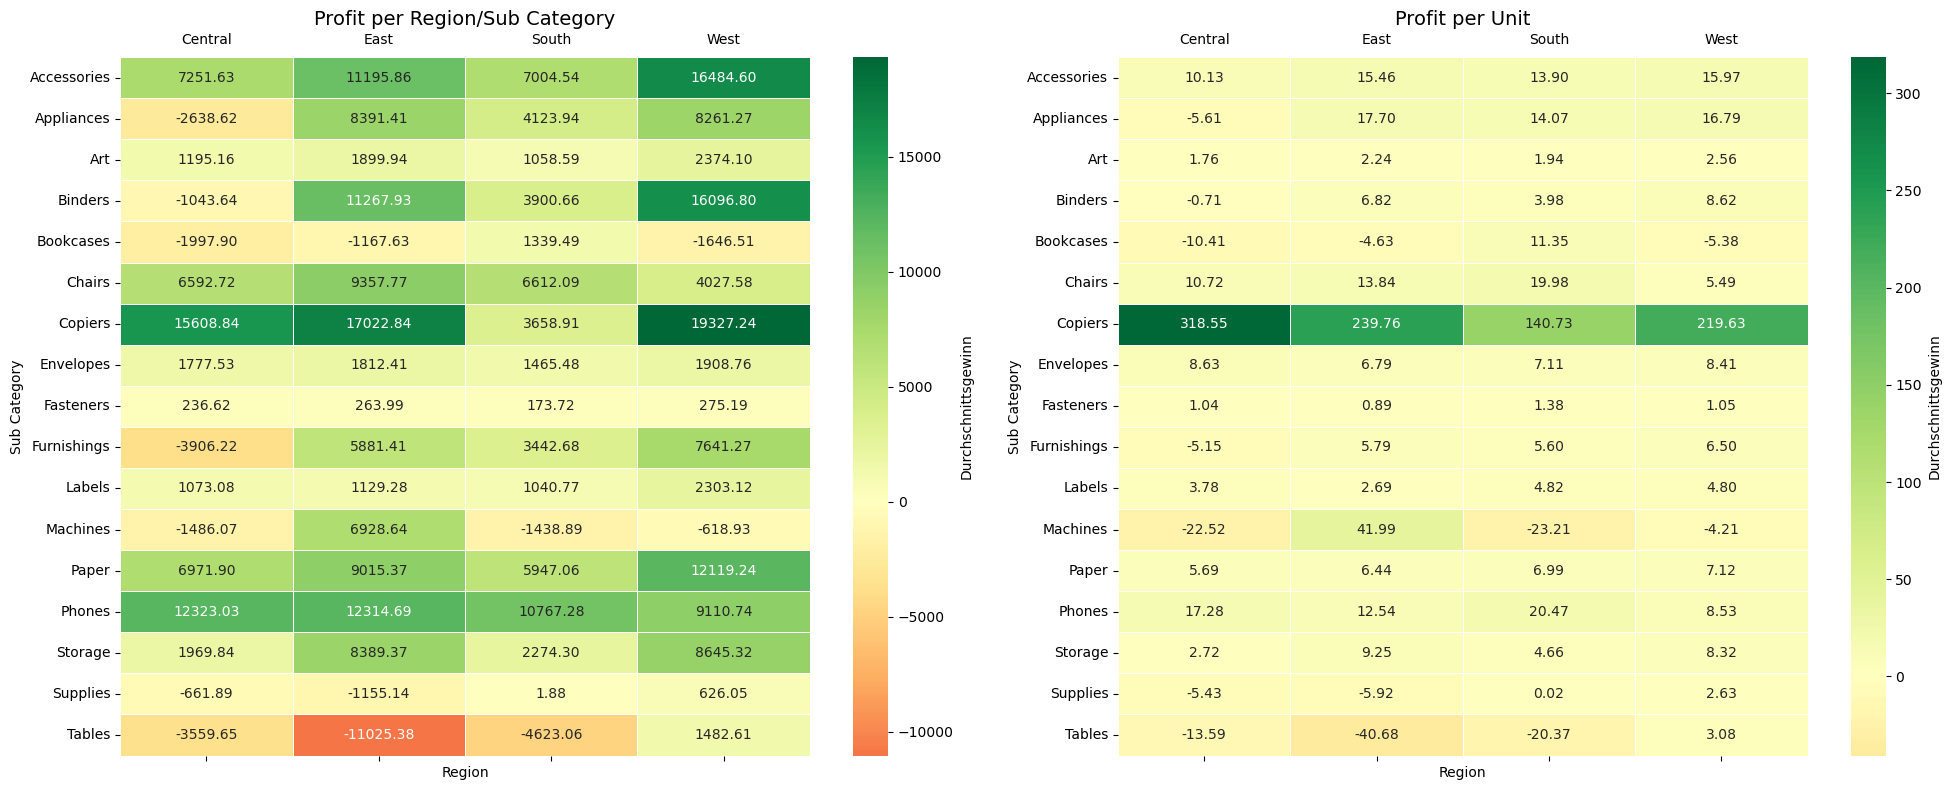

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) 

gen_plot(
    df_profit_sum_sub_category_region, 
    None, 
    "Profit per Region/Sub Category", 
    "Region", 
    "Sub Category", 
    ax=ax1
)

gen_plot(
    df_profit_sum_sub_category_region, 
    df_quantity_sum_sub_category_region, 
    "Profit per Unit", 
    "Region", 
    "Sub Category", 
    ax=ax2
)

plt.tight_layout()
plt.show()

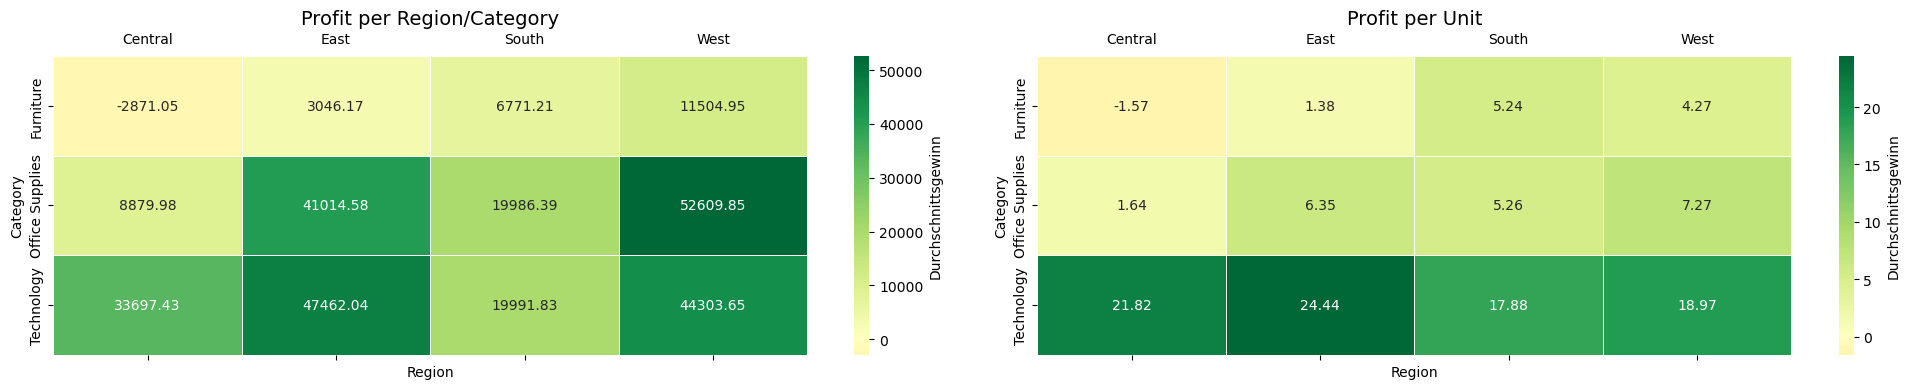

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4)) 
gen_plot(
    df_profit_sum_category_region, 
    None, 
    "Profit per Region/Category", 
    "Region", 
    "Category", 
    ax=ax1
)
gen_plot(
    df_profit_sum_category_region, 
    df_quantity_sum_category_region, 
    "Profit per Unit", 
    "Region", 
    "Category", 
    ax=ax2
)
plt.tight_layout()
plt.show()

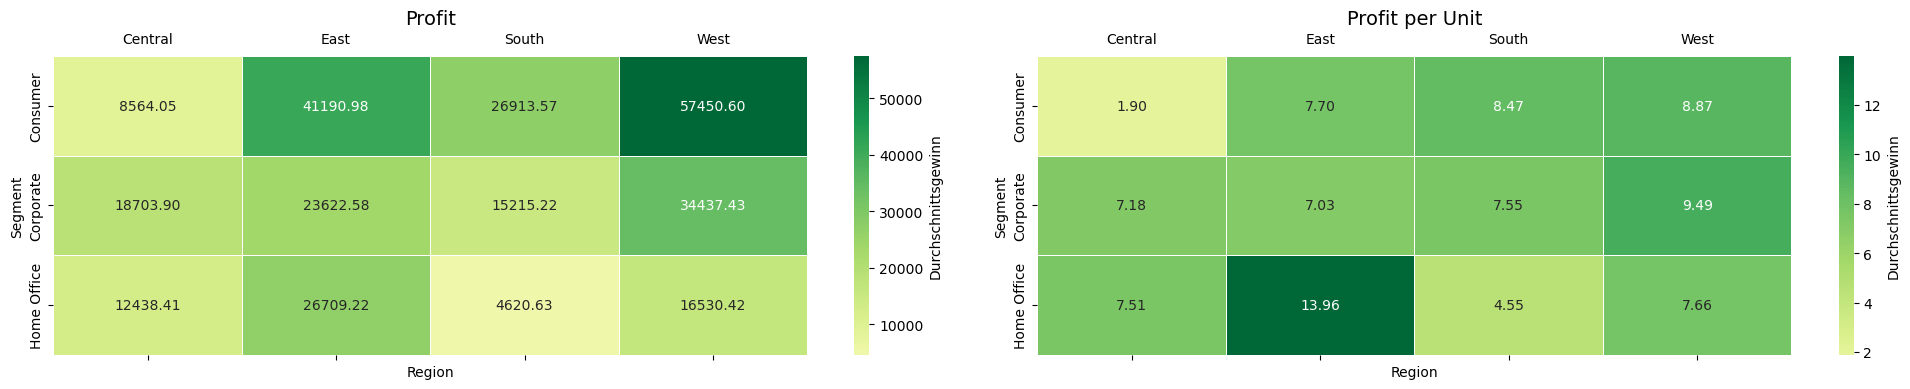

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4)) 
gen_plot(
    df_profit_sum_segment_region, 
    None, 
    "Profit", 
    "Region", 
    "Segment", 
    ax=ax1
)
gen_plot(
    df_profit_sum_segment_region, 
    df_quantity_sum_segment_region, 
    "Profit per Unit", 
    "Region", 
    "Segment", 
    ax=ax2
)
plt.tight_layout()
plt.show()

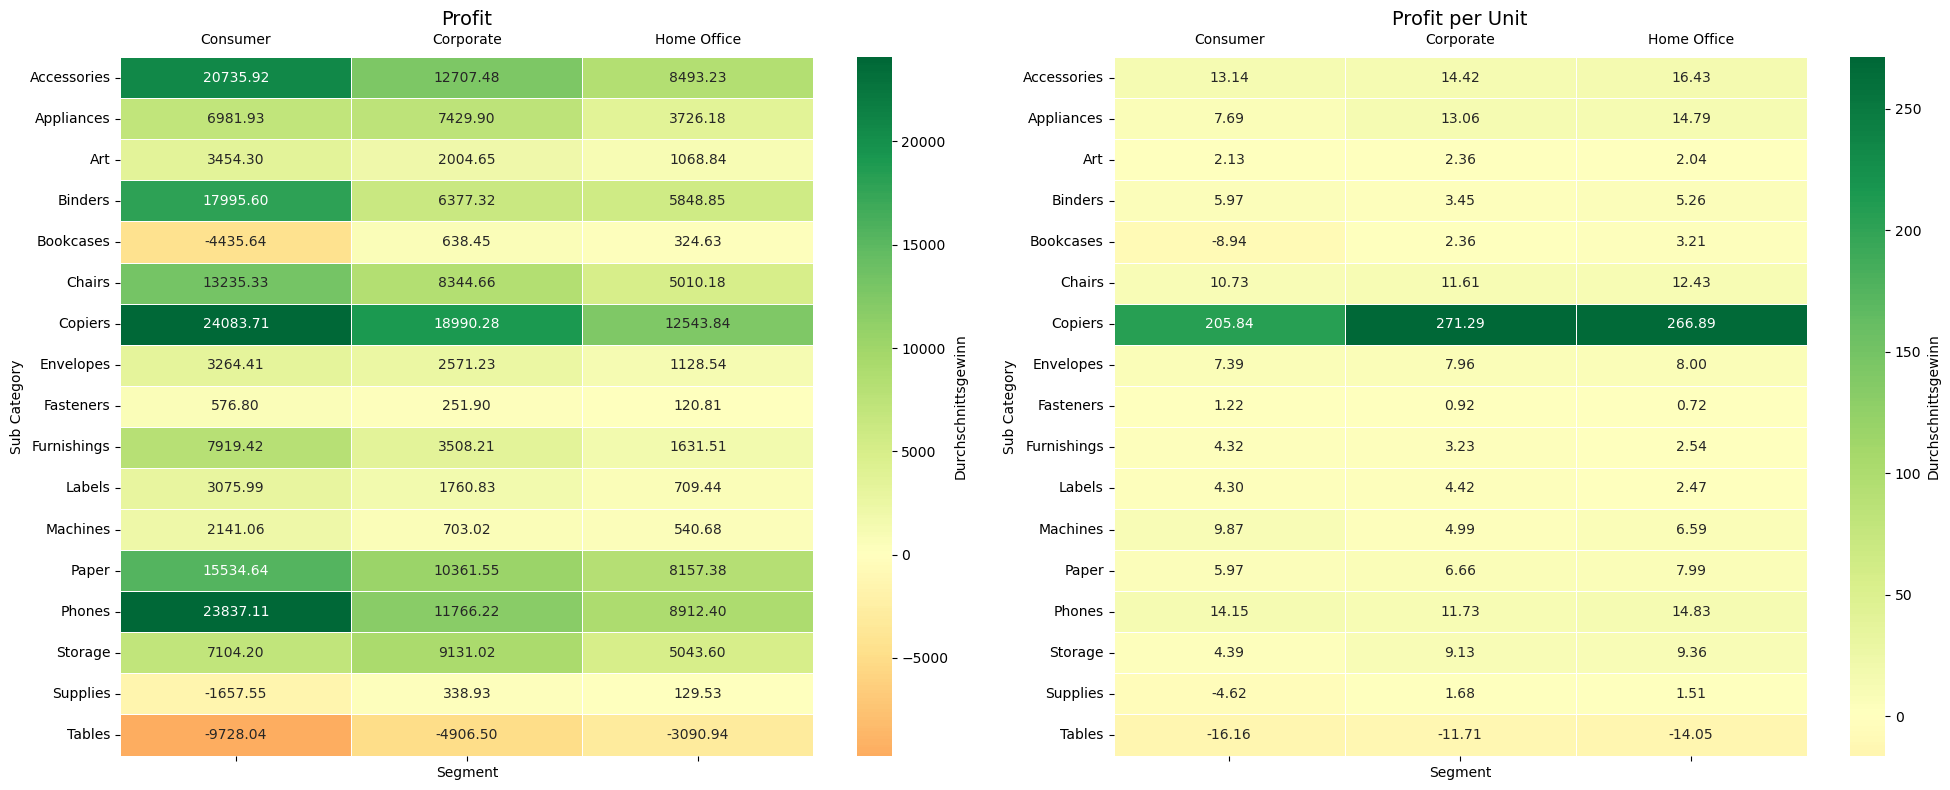

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) 
gen_plot(
    df_profit_sum_sub_category_segment, 
    None, 
    "Profit", 
    "Segment", 
    "Sub Category", 
    ax=ax1 
)
gen_plot(
    df_profit_sum_sub_category_segment, 
    df_quantity_sum_sub_category_segment, 
    "Profit per Unit", 
    "Segment", 
    "Sub Category", 
    ax=ax2 
)
plt.tight_layout()
plt.show()

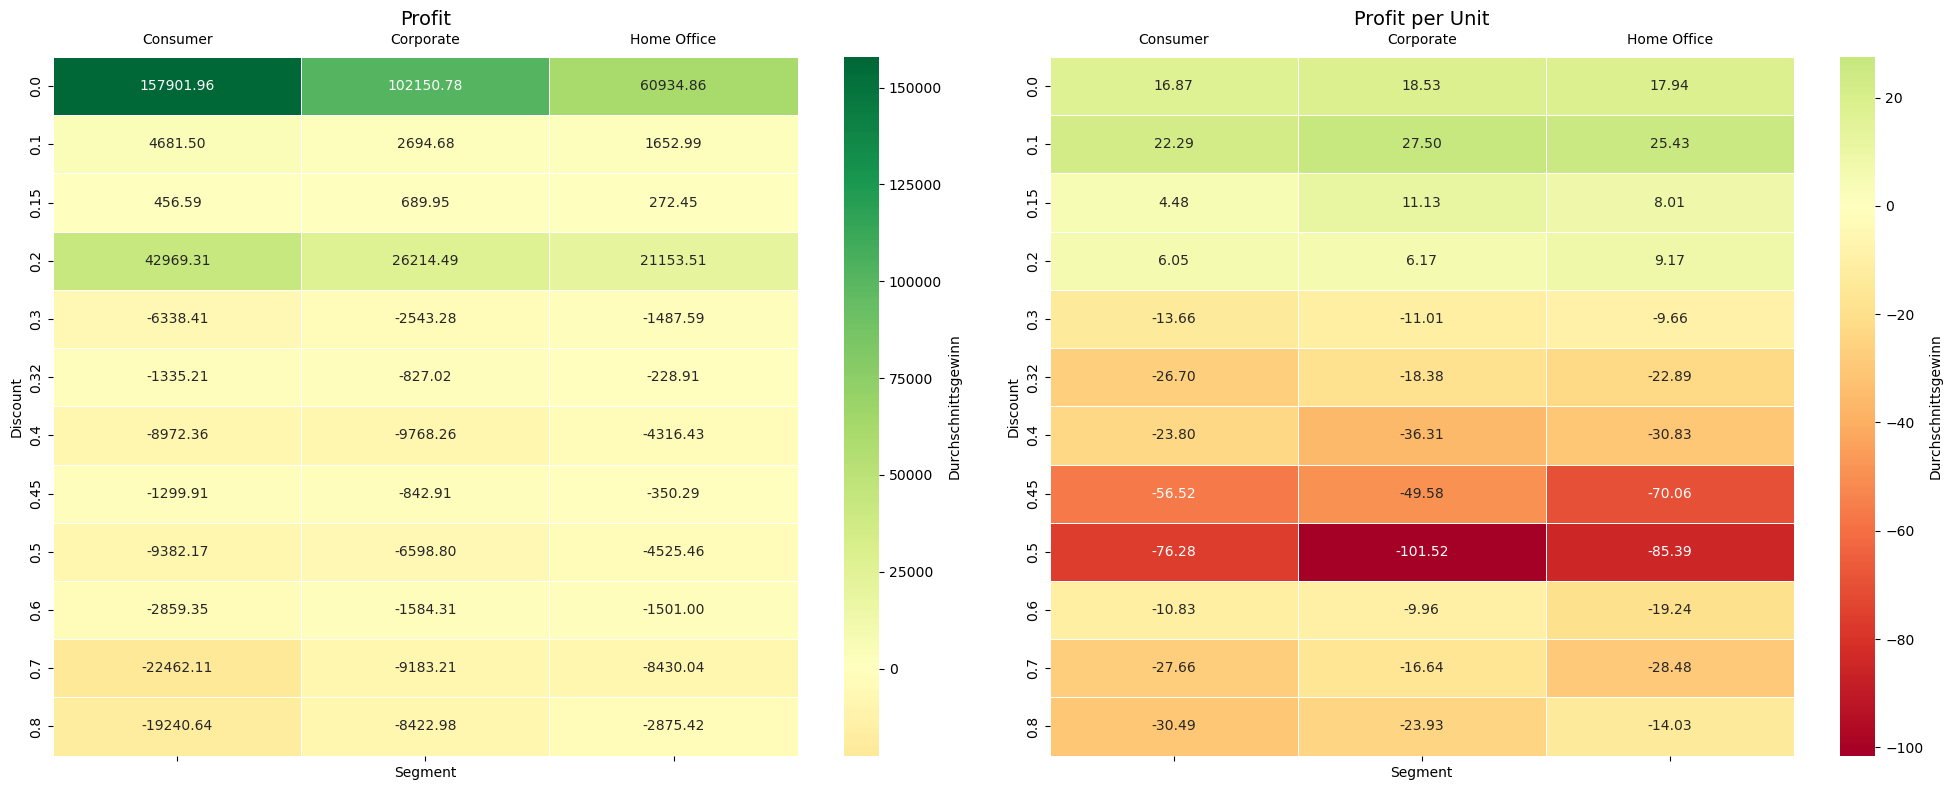

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) 
gen_plot(
    df_profit_sum_discount_segment, 
    None, 
    "Profit", 
    "Segment", 
    "Discount", 
    ax=ax1 
)
gen_plot(
    df_profit_sum_discount_segment, 
    df_quantity_sum_discount_segment, 
    "Profit per Unit", 
    "Segment", 
    "Discount", 
    ax=ax2 
)
plt.tight_layout()
plt.show()

## Korrelationen

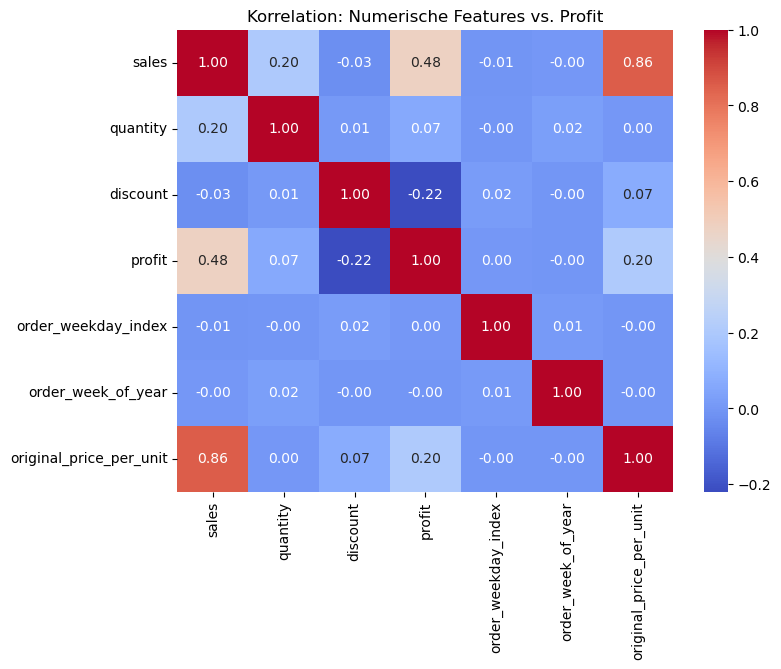

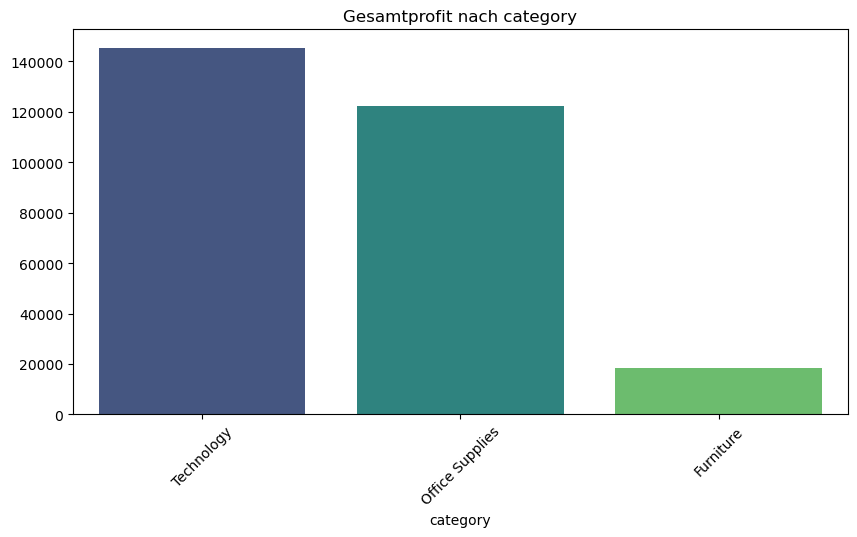

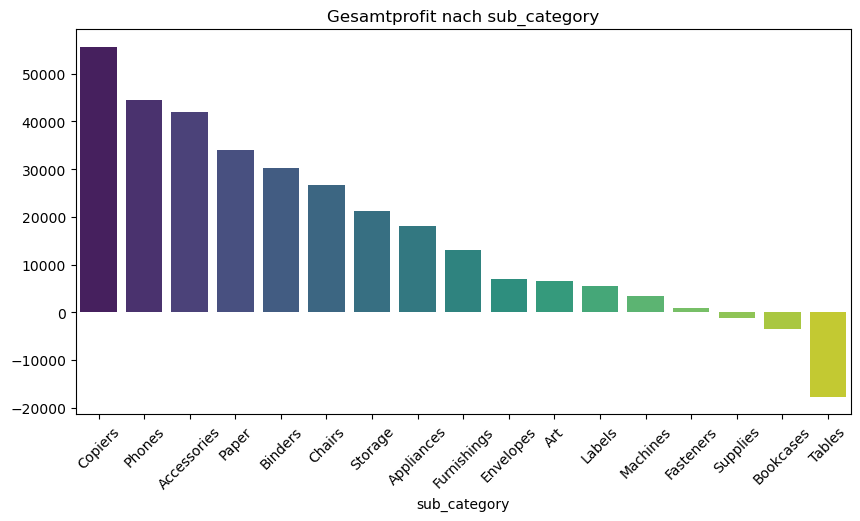

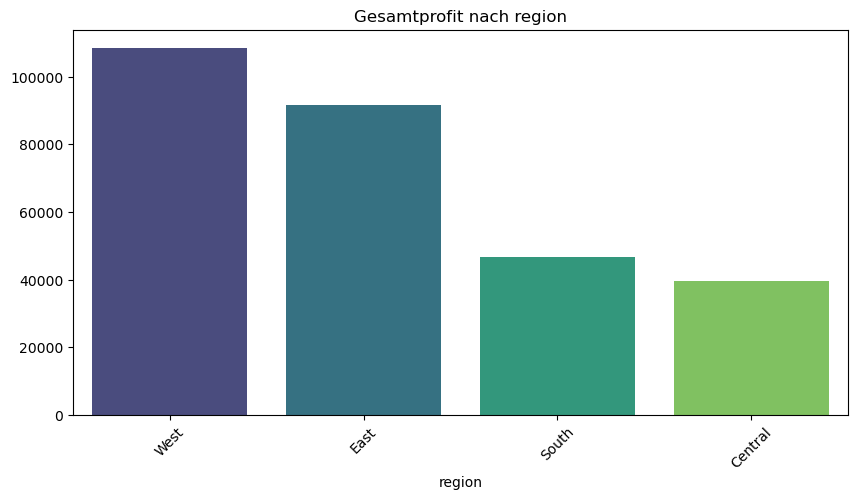

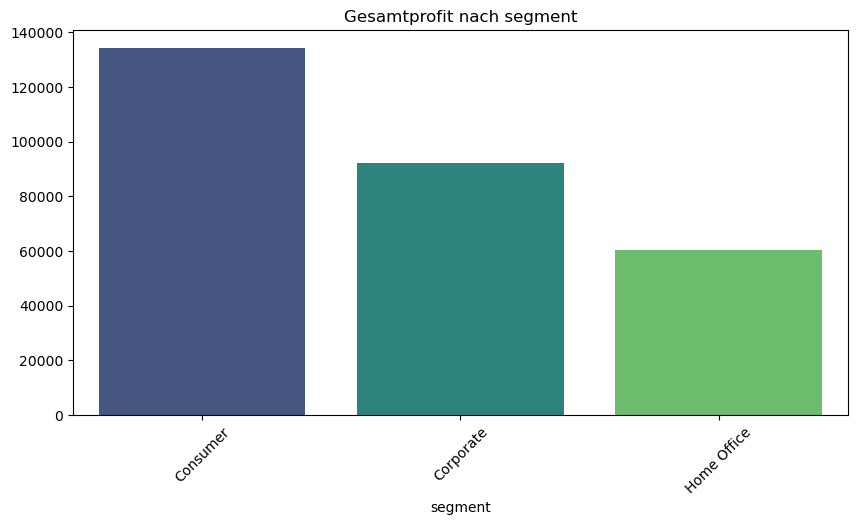

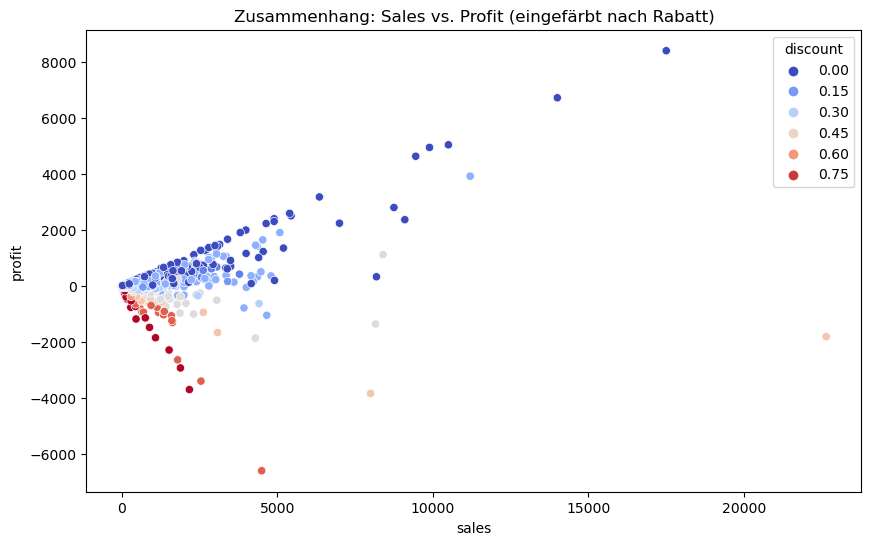

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Numerische Korrelationsmatrix (Heatmap)
# Wir wählen nur echte numerische Spalten (ohne IDs und Datum)
numeric_cols = ['sales', 'quantity', 'discount', 'profit','order_weekday_index', 'order_week_of_year',"original_price_per_unit"]
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelation: Numerische Features vs. Profit")
plt.show()

# 2. Analyse der Kategorien (Bsp: Kategorie & Sub-Kategorie)
# Zeigt, welche Produkte Gewinnbringer oder Verlustgeschäfte sind
cols_to_check = ['category', 'sub_category', 'region', 'segment']

for col in cols_to_check:
    plt.figure(figsize=(10, 5))
    # Wir summieren den Profit pro Kategorie, um den Gesamteffekt zu sehen
    profit_by_cat = df.groupby(col)['profit'].sum().sort_values(ascending=False)
    sns.barplot(x=profit_by_cat.index, y=profit_by_cat.values, palette="viridis")
    plt.title(f"Gesamtprofit nach {col}")
    plt.xticks(rotation=45)
    plt.show()

# 3. Der Einfluss von Rabatt (Discount) auf Profit (Scatterplot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sales', y='profit', hue='discount', palette='coolwarm')
plt.title("Zusammenhang: Sales vs. Profit (eingefärbt nach Rabatt)")
plt.show()

Korrelation mit Profit:
 profit                     1.000000
sales                      0.479064
original_price_per_unit    0.204591
quantity                   0.066253
ship_day                   0.007180
order_year                 0.004670
ship_year                  0.004531
order_weekday_index        0.000200
ship_month                -0.000951
order_day                 -0.002965
delivery_time             -0.004649
discount                  -0.219487
Name: profit, dtype: float64


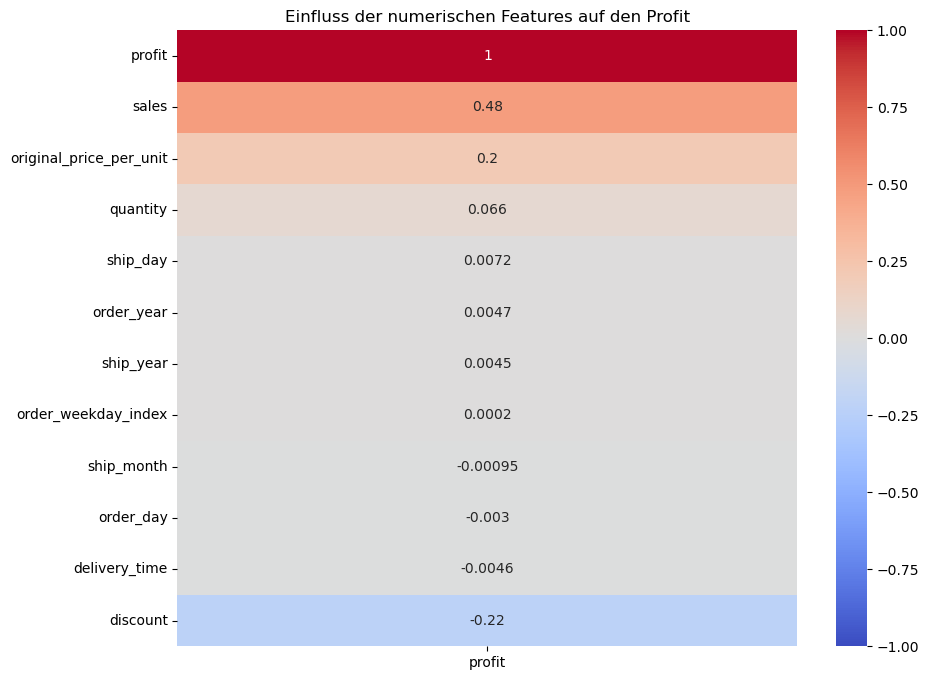

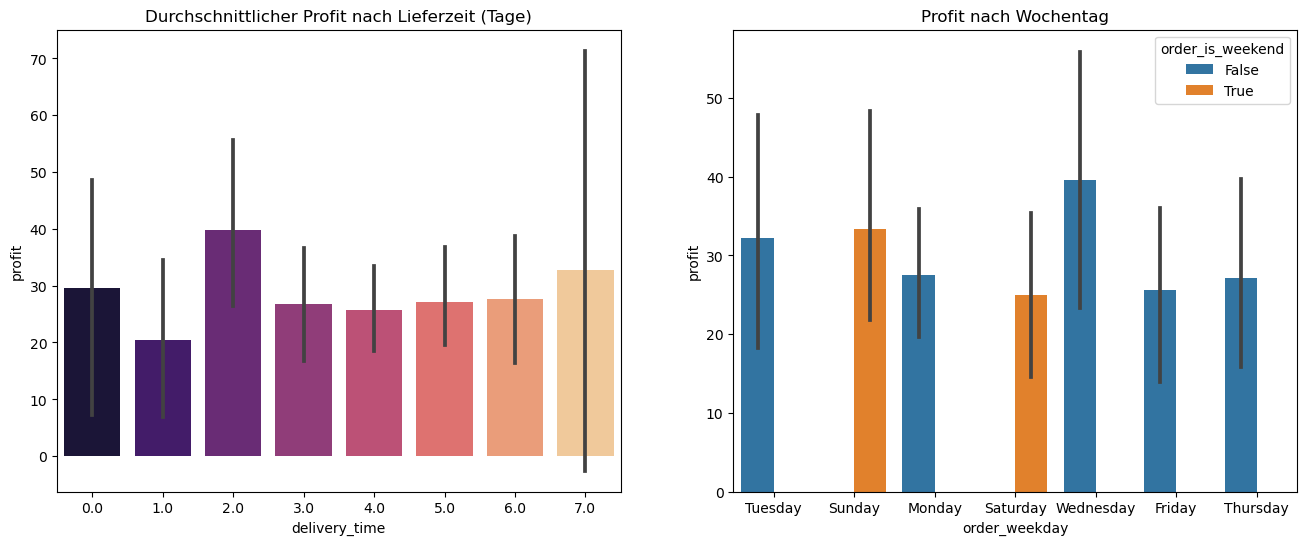

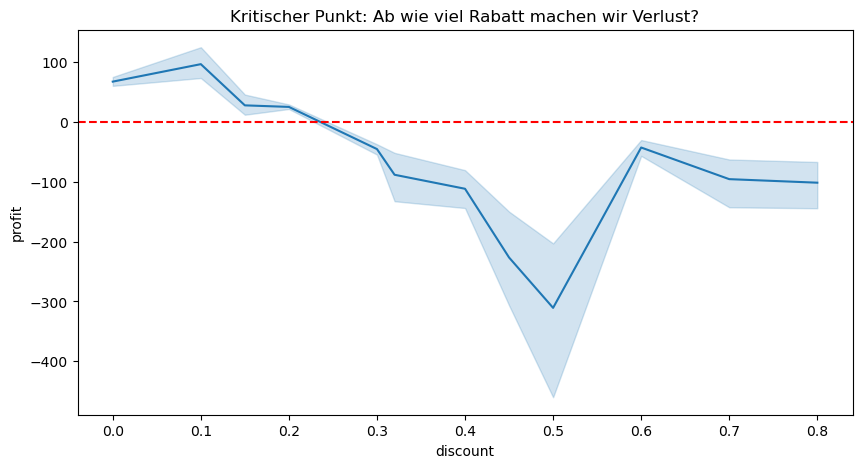

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_cleaned_salesdata = df.copy()
# 1. Datenbereinigung für die Analyse
# Wir erstellen eine Kopie und werfen IDs und rohe Datumsformate raus
cols_to_drop = ['row_id', 'order_id', 'customer_id', 'customer_name', 
                'product_id', 'product_name', 'postal_code', 'order_date', 'ship_date']

# Nur Spalten behalten, die im DataFrame existieren
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned_salesdata.columns]
df_analysis = df_cleaned_salesdata.drop(columns=existing_cols_to_drop)

# 2. Numerische Korrelationsmatrix (inklusive delivery_time)
plt.figure(figsize=(10, 8))
# Wähle nur numerische Datentypen
numeric_df = df_analysis.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_df.corr()

# Fokus auf die Zeile "profit", sortiert nach Stärke
profit_corr = corr_matrix['profit'].sort_values(ascending=False)
print("Korrelation mit Profit:\n", profit_corr)

sns.heatmap(corr_matrix[['profit']].sort_values(by='profit', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Einfluss der numerischen Features auf den Profit")
plt.show()

# 3. Blick auf deine neuen Features: Delivery Time & Wochentag
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Profit nach Lieferdauer
sns.barplot(data=df_cleaned_salesdata, x='delivery_time', y='profit', ax=ax[0], palette="magma")
ax[0].set_title("Durchschnittlicher Profit nach Lieferzeit (Tage)")

# Profit nach Wochentag (0=Montag, 6=Sonntag)
sns.barplot(data=df_cleaned_salesdata, x='order_weekday', y='profit', hue='order_is_weekend', ax=ax[1])
ax[1].set_title("Profit nach Wochentag")

plt.show()

# 4. Der "Discount-Check" (Das ist meist der wichtigste ML-Faktor)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned_salesdata, x='discount', y='profit')
plt.title("Kritischer Punkt: Ab wie viel Rabatt machen wir Verlust?")
plt.axhline(0, color='red', linestyle='--') # Nulllinie
plt.show()

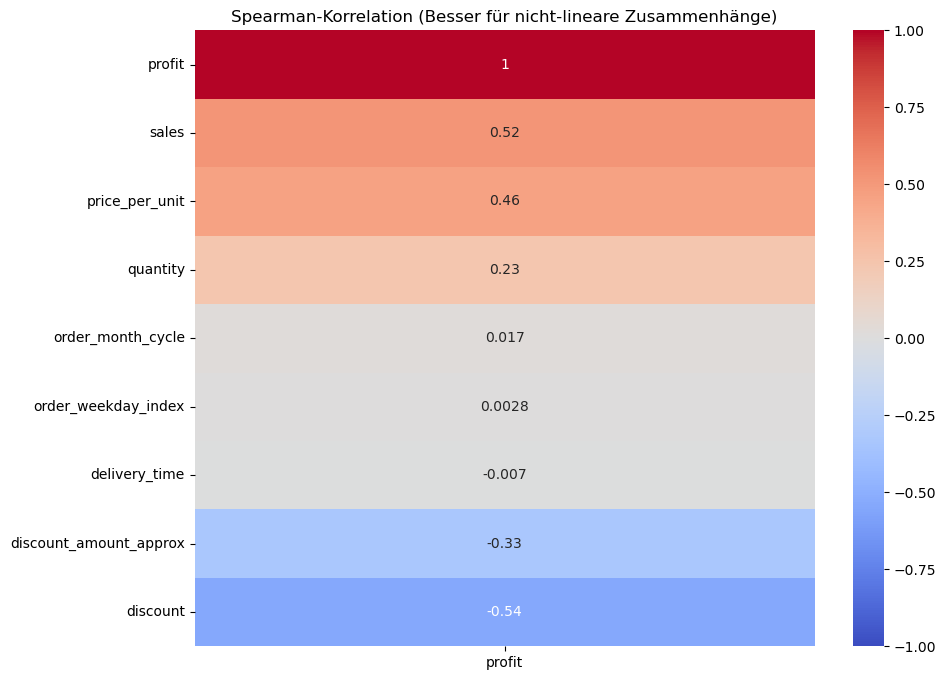

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Datum korrigieren: Wir wollen Zyklen (1-12), keine Zeitstempel
# Wir extrahieren den reinen Monat (int) aus dem order_date
df_cleaned_salesdata['order_month_cycle'] = pd.to_datetime(df_cleaned_salesdata['order_date']).dt.month

# 2. Neue "Interaktions-Features" erstellen
# ML-Modelle lieben es, wenn man ihnen Zusammenhänge vorrechnet.
# Ein hoher Rabatt bei hohem Umsatz drückt den Profit stärker als bei kleinem Umsatz.
df_cleaned_salesdata['discount_amount_approx'] = df_cleaned_salesdata['sales'] * df_cleaned_salesdata['discount']
df_cleaned_salesdata['price_per_unit'] = df_cleaned_salesdata['sales'] / df_cleaned_salesdata['quantity']

# 3. Auswahl der Features für die Analyse
# Wir trennen in numerische Prädiktoren und kategorische Prädiktoren
numeric_features = [
    'sales', 'quantity', 'discount', 
    'delivery_time', 'price_per_unit', 'discount_amount_approx',
    'order_month_cycle', 'order_weekday_index'
]

target = 'profit'

# 4. Korrelation berechnen (Spearman statt Pearson!)
# Warum? Pearson misst nur lineare Linien. Deine Discount-Kurve ist aber NICHT linear.
# Spearman erkennt auch gebogene Zusammenhänge besser.
corr_matrix = df_cleaned_salesdata[numeric_features + [target]].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['profit']].sort_values(by='profit', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman-Korrelation (Besser für nicht-lineare Zusammenhänge)")
plt.show()

In [81]:
import numpy as np

# 1. Der "Discount-Alarm" (Binäres Feature)
# Hilft dem Modell, die Verlustzone sofort zu erkennen (siehe Insight 1)
df_cleaned_salesdata['is_discount_critical'] = (df_cleaned_salesdata['discount'] > 0.2).astype(int)

# 2. Profitabilität pro Einheit (Proxy für Marge)
# Wir wissen aus der Heatmap, dass price_per_unit wichtig ist.
# Wir kombinieren das mit dem Rabatt.
df_cleaned_salesdata['effective_unit_price'] = (df_cleaned_salesdata['sales'] / df_cleaned_salesdata['quantity']) * (1 - df_cleaned_salesdata['discount'])

# 3. Log-Transformation für Sales
# Sales Werte schwanken extrem (von 1$ bis 20.000$). Das stört viele Modelle.
# Wir "stauchen" die Werte mit dem Logarithmus zusammen.
df_cleaned_salesdata['log_sales'] = np.log1p(df_cleaned_salesdata['sales'])

# Check der neuen Korrelationen
new_features = ['is_discount_critical', 'effective_unit_price', 'log_sales', 'profit']
print(df_cleaned_salesdata[new_features].corr(method='spearman'))

                      is_discount_critical  effective_unit_price  log_sales  \
is_discount_critical              1.000000             -0.179138  -0.050771   
effective_unit_price             -0.179138              1.000000   0.919216   
log_sales                        -0.050771              0.919216   1.000000   
profit                           -0.549880              0.532246   0.518407   

                        profit  
is_discount_critical -0.549880  
effective_unit_price  0.532246  
log_sales             0.518407  
profit                1.000000  


Training mit 7995 Zeilen und 30 Features...
--- Modell Ergebnis ---
R² Score: 0.0270 (1.0 wäre perfekt, 0.0 ist raten)
MAE (Mittlerer Fehler): 25.42 $
-----------------------


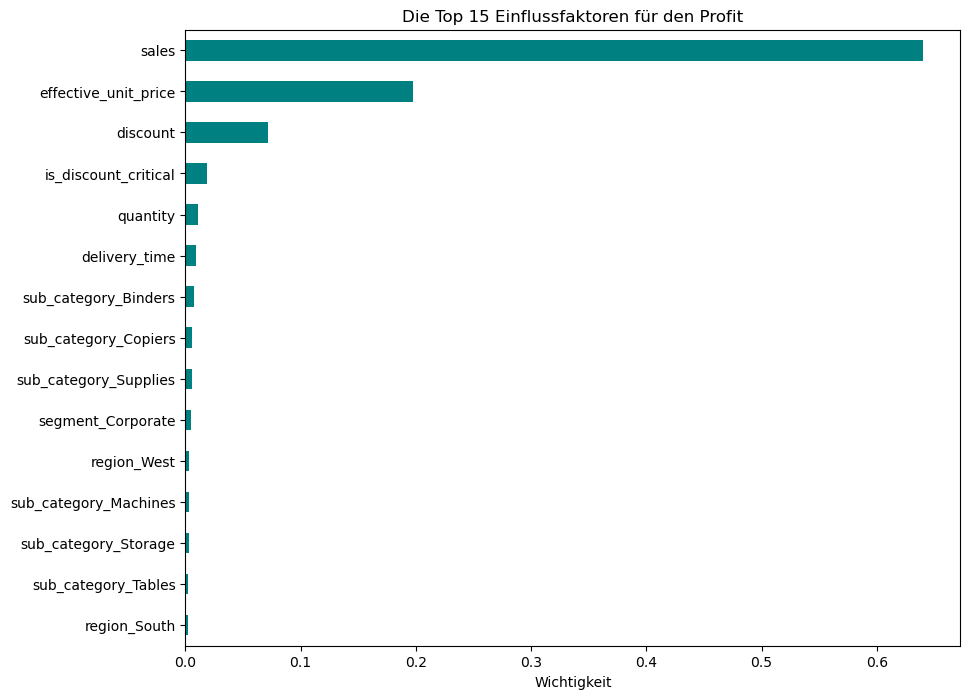

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Feature Auswahl
# Wir nehmen deine neuen Features + die wichtigsten alten.
# WICHTIG: Wir müssen Text-Spalten (Kategorien) in Zahlen umwandeln ("One-Hot-Encoding")
cols_for_model = [
    'sales', 'quantity', 'discount', 'delivery_time',  # Basis Zahlen
    'effective_unit_price', 'is_discount_critical',    # Deine neuen Features
    'sub_category', 'region', 'segment', 'ship_mode'   # Kategorien (Text)
]

# Erstelle ein sauberes DataFrame nur für das Modell
df_model = df_cleaned_salesdata[cols_for_model].copy()

# One-Hot-Encoding: Macht aus "sub_category" -> "sub_category_Chairs": 1, "sub_category_Tables": 0 etc.
df_model = pd.get_dummies(df_model, drop_first=True)

# Zielvariable definieren
X = df_model
y = df_cleaned_salesdata['profit']

# 2. Split in Training (80%) und Test (20%)
# Damit wissen wir, ob das Modell wirklich lernt oder nur auswendig lernt.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training mit {X_train.shape[0]} Zeilen und {X_train.shape[1]} Features...")

# 3. Das Modell trainieren (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 4. Vorhersage und Bewertung
predictions = model.predict(X_test)

# Metriken berechnen
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("--- Modell Ergebnis ---")
print(f"R² Score: {r2:.4f} (1.0 wäre perfekt, 0.0 ist raten)")
print(f"MAE (Mittlerer Fehler): {mae:.2f} $")
print("-----------------------")

# 5. Was war dem Modell am wichtigsten? (Feature Importance Plot)
importances = model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10, 8))
feat_importances.nlargest(15).plot(kind='barh', color='teal')
plt.title("Die Top 15 Einflussfaktoren für den Profit")
plt.xlabel("Wichtigkeit")
plt.gca().invert_yaxis() # Wichtigstes oben
plt.show()